# Image retrieval with prompts

In this notebook, we explore how to use CLIP to retrieve images using prompts.
We will apply the following steps:
* Install required packages
* Load a dataset (CIFAR10 here)
* Extract the embeddings of the images and store them in a FAISS index
* Compute embedding for a given prompt (e.g. a dog)
* Retrieve top-k images similar to the given prompt

## Install required packages

In [ ]:
pip install transformers torch datasets


## Install FAISS with GPU or CPU support
For CPU only, install faiss-cpu.
For GPU, install faiss-gpu.
Uncomment the line below that fits your hardware and run.

In [ ]:
#pip install faiss-gpu
#pip install faiss-cpu

## Load CLIP: model, processor and tokenizer using transformers

In [12]:
#Import packages
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
from datasets import load_dataset
import faiss
import numpy as np
from tqdm import tqdm

#Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model, processor and tokenizer
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

## Load CIFAR 10 dataset
We use this dataset as it is rather small. For this demo, we will only keep the train set and limit its size to 10.000 images.

Found cached dataset cifar10 (/home/user/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1178.84it/s]
Loading cached processed dataset at /home/user/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-df2177be1953d758.arrow


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


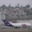

In [10]:
#Load cifar10 dataset
dataset = load_dataset("cifar10")

#Limit size to 10000 images
from datasets import Dataset
train_dataset = dataset["train"].filter(lambda example, idx: idx < 10000, with_indices=True)
print(train_dataset)

#Display an image
display(train_dataset[0]['img'])

## Extract the features of all images in the train set (10K images) and store them in a FAISS index
In order to perform image retrieval with prompts, we need to extract the features of all the images of the dataset.
We will store the features in a FAISS index. The dimensionality of the features is 512 for the clip-vit-base-patch32 model. Therefore, we create an index with the parameter 512.
We define 2 functions for this purpose:
* extract_features_clip: takes an image as input and return its features.
* add_vector_to_index: add the image features to a FAISS index. Before, it preprocesses the vector to fit FAISS requirements (i.e. numpy float 32 vector) and normalizes the vector.

Lastly, we iterate over the dataset to extract and store the features.

In [13]:
#Add a vector to FAISS index
def add_vector_to_index(embedding, index):
    #convert embedding to numpy
    vector = embedding.detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector: important
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

#Extract features of a given image
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features

#FAISS index
index = faiss.IndexFlatL2(512)

#Process the dataset to extract all features and store in index
for image in tqdm(train_dataset):
    clip_features = extract_features_clip(image['img'])
    add_vector_to_index(clip_features,index)
    
#Write index locally. Not needed after but can be useful for future retrieval
faiss.write_index(index,"clip.index")

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:51<00:00, 89.60it/s]


## Image retrieval with prompts
Now that all the images are indexed, we can retrieve the top-k images matching a specific prompt.
To do so, we first need to extract the text features from the input prompt. Then, we search the FAISS index with the text features and retrieve 5 (for instance) images. We get in return two variables:
* distances: array of euclidian distances between the prompt and the images retrieved.
* indices: indices of the images retrieved.

In [16]:
#Let's search images of dogs
prompt="a photo of a dog"

#Tokenize the prompt and extract features
text_token = tokenizer([prompt], return_tensors="pt").to(device)
text_features = model.get_text_features(**text_token)

#Preprocess the vector before search in FAISS index
text_np = text_features.detach().cpu().numpy()
text_np = np.float32(text_np)
faiss.normalize_L2(text_np)

#Search the top 5 images
distances, indices = index.search(text_np, 5)
print('distances',distances)
print('indices' ,indices)

distances [[1.4080683 1.4112686 1.4138402 1.4166881 1.4236143]]
indices [[3674  375 4180 6782 3917]]


For each retrieved image, we compute its similarity score (ranging from 0 to 1) and display the image alongside its corresponding score.

Indice: 3674 , Similarity score: 41.52706135010295


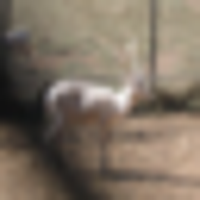

Indice: 375 , Similarity score: 41.47194565413372


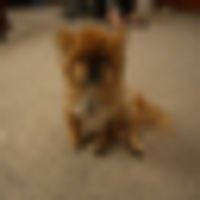

Indice: 4180 , Similarity score: 41.427763548373505


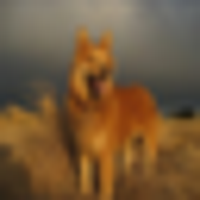

Indice: 6782 , Similarity score: 41.37894362004689


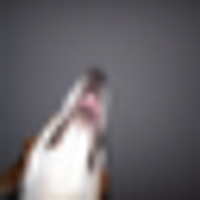

Indice: 3917 , Similarity score: 41.2606913173395


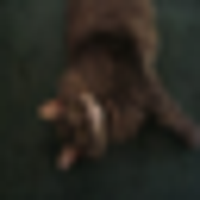

In [17]:
#For each top-5 results, compute similarity score between 0 and 1, print indice, similarity score and display image 
for i,v in enumerate(indices[0]):
    sim = (1/(1+distances[0][i])*100)
    print(f"Indice: {v} , Similarity score: {sim}")
    img_resized = train_dataset[int(v)]['img'].resize((200, 200))
    display(img_resized)